Welcome. This notebook can be used to try out the Stable Image Services. This implementation can be used in your production environment if you are developing an application using the API.

New to colab? Just hit the play button on each of the cells and follow instructions.

You will need an account on https://platform.stability.ai/ to use the features.

Have fun and do great things.

In [1]:
#@title Install requirements
from io import BytesIO
import IPython
import json
import os
from PIL import Image
import requests
import time
from google.colab import output

In [2]:
#@title Connect to the Stability API

import getpass
# @markdown To get your API key visit https://platform.stability.ai/account/keys
STABILITY_KEY = getpass.getpass('Enter your API Key')



Enter your API Key··········


In [3]:
#@title Define functions

def send_generation_request(
    host,
    params,
    files = None
):
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    if files is None:
        files = {}

    # Encode parameters
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

def send_async_generation_request(
    host,
    params,
    files = None
):
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    if files is None:
        files = {}

    # Encode parameters
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    # Process async response
    response_dict = json.loads(response.text)
    generation_id = response_dict.get("id", None)
    assert generation_id is not None, "Expected id in response"

    # Loop until result or timeout
    timeout = int(os.getenv("WORKER_TIMEOUT", 500))
    start = time.time()
    status_code = 202
    while status_code == 202:
        print(f"Polling results at https://api.stability.ai/v2beta/results/{generation_id}")
        response = requests.get(
            f"https://api.stability.ai/v2beta/results/{generation_id}",
            headers={
                **headers,
                "Accept": "*/*"
            },
        )

        if not response.ok:
            raise Exception(f"HTTP {response.status_code}: {response.text}")
        status_code = response.status_code
        time.sleep(10)
        if time.time() - start > timeout:
            raise Exception(f"Timeout after {timeout} seconds")

    return response

# Edit

Stable Image editing services include four offerings currently in production:

- Inpaint: where you specify a `mask` (or use the alpha channel of the `image` parameter). The `prompt` is what will be added to the image in the masked area. Regardless of input resolution, the output will be provided at 4mp. This service will use 3 credits.
- Outpaint: Extend an image in any direction. This service will use 4 credits.
- Search-and-Recolor: where you specify what you want to recolor in the input image via `select_prompt`. The `prompt` is what will be added to the image in place of the object from the select_prompt. The resolution of the generated image will match the resolution of the input image. This service will use 5 credits.
- Search-and-Replace: where you specify what you want to replace in the input image via `search_prompt`. The `prompt` is what will be added to the image in place of the object from the search_prompt. Regardless of input resolution, the output will be provided at 4mp. This service will use 4 credits.
- Erase: Remove unwanted objects, such as blemishes on portraits or items on desks, using image masks. This service will use 3 credits.
- Remove Background: Removes the background from an image. This service will use 2 credits.
- Replace Background and Relight: Swap backgrounds with AI-generated or uploaded images while adjusting lighting to match the subject. This service will use 8 credits.

See https://platform.stability.ai/docs/api-reference#tag/Edit

Try these services out in the sections below. Check back in for regular updates.

Feedback welcome.

Sending REST request to https://api.stability.ai/v2beta/stable-image/edit/erase...
Saved image edited_cjgj2-alpha_911891674.webp


<IPython.core.display.Javascript object>

Original image:


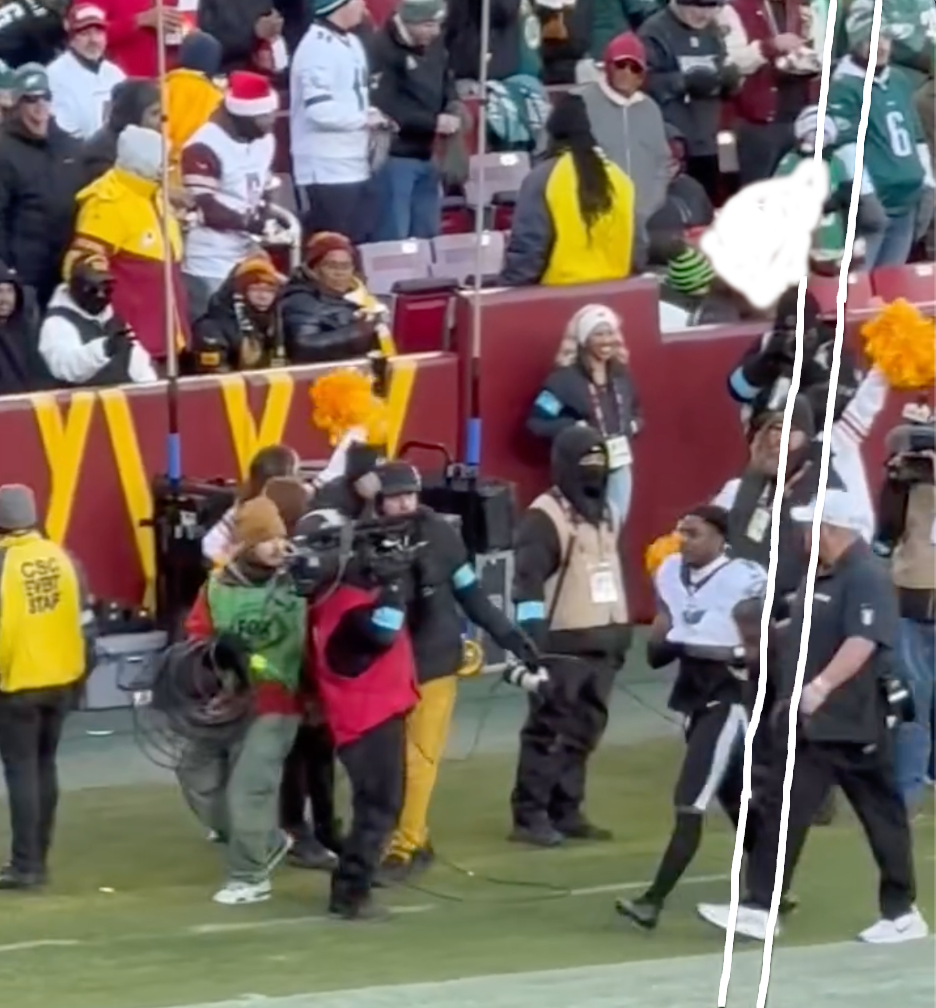

Result image:


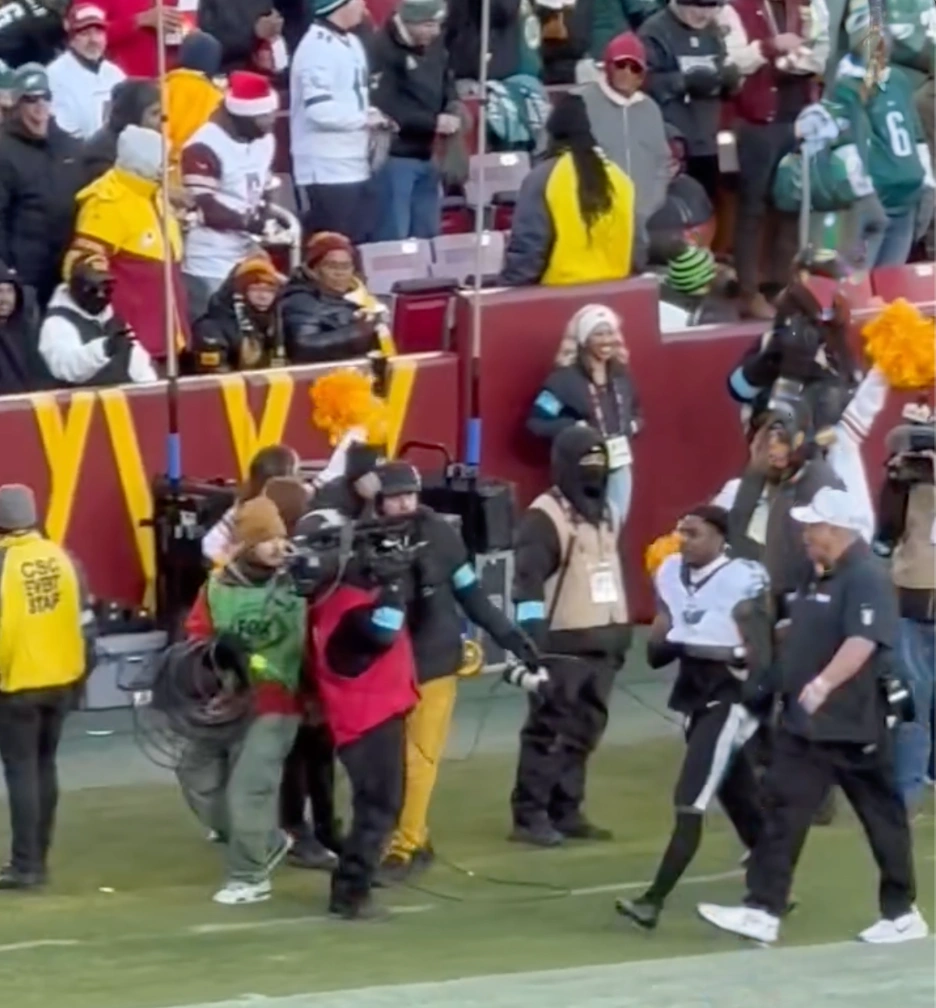

In [4]:
#@title Erase

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image/mask field below
#@markdown <br><br>

image = "/content/cjgj2-alpha.png" #@param {type:"string"}
mask = "" #@param {type:"string"}
seed = 0 #@param {type:"integer"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/erase"

params = {
    "image" : image,
    "mask" : mask,
    "output_format": output_format,
    "seed" : seed,
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))